In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: BONOMO, TOMMASO (1511831)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

To construct a baseline model I started with a network that would have small capacity for the given task (3 hidden dense layers of 100, 50, 20 neurons each). This network trained until a validation accuracy of around 0.75, then the loss flattened out. I then increased the number of neurons for each layer, stopping when I started to have diminishing returns. I found that the optimizer Adam performed much better than RMSprop, at standard learning rate. The model clearly overfits. (length: 483)



Max val score: 82.16%


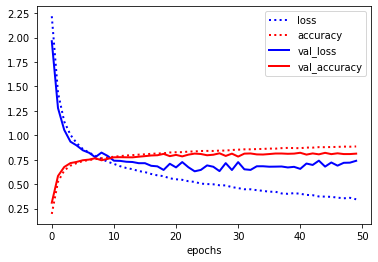

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 700)               2151100   
_________________________________________________________________
dense_3 (Dense)              (None, 300)               210300    
_________________________________________________________________
dense_4 (Dense)              (None, 120)               36120     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1210      
Total params: 2,398,730
Trainable params: 2,398,730
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    model = models.Sequential([
        layers.Reshape((3072,), input_shape=(32,32,3

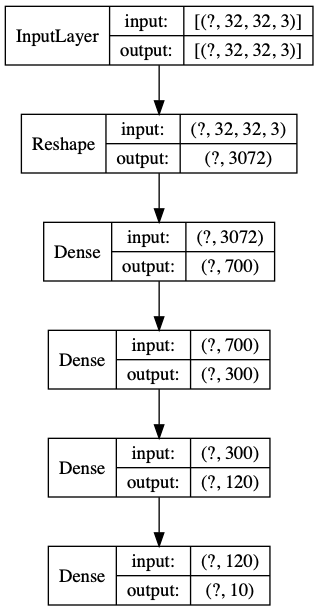

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

For grayscale, we have 3 times less weights to learn in the first Dense layer (205k instead of 614k). Improvements are only marginal: 1% better on the validation accuracy. This could be explained by the efficiency of the ReLU activation in quickly bringing to zero the weights of the extra noise in the RGB model. This model appears to also appears to overfit less, but not by a big margin. It still overfits significantly. (length: 424)



Max val score: 83.14%


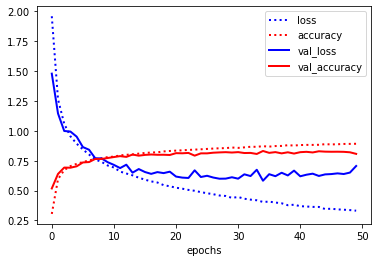

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 700)               717500    
_________________________________________________________________
dense_11 (Dense)             (None, 300)               210300    
_________________________________________________________________
dense_12 (Dense)             (None, 120)               36120     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1210      
Total params: 965,130
Trainable params: 965,130
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    model = models.Sequential([
        layers.Reshape((1024,), input_shape=(32,32,1))

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

I added Dropout and BatchNormalization layers in between Dense layers to brake up unimportant relationships and normalise the activations. This decreased the model capacity to a point of underfitting. Therefore I used SELU activation instead of ReLU because it was killing too many nodes. This worked in part. I then tuned the dropout rate (in interval [0, 0.5]) and Adam's learning rate (chosen in {0.001, 0.0001, 1e-05, 1e-06}) through the HyperBand algorithm. Results are good but not excellent. (length: 499)



Max val score: 87.59%


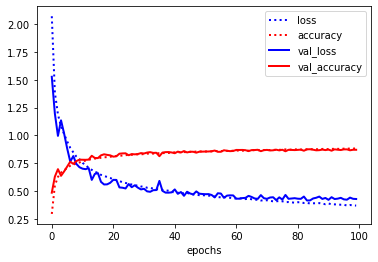

def build_model_1_3():
    model = models.Sequential([
        layers.Reshape((1024,), input_shape=(32,32,1)),
        layers.Dense(700, activation="selu"),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        layers.Dense(300, activation="selu"),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(120, activation="selu"),
        layers.Dropout(0.45),
        layers.BatchNormalization(),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I started by alternating between a Convolutional layer and a Max Pooling layer, but I could not construct a very deep network because of the halving in size done by Max Pooling. The results were good but not great. I had to stack more than one Conv layer between each Max Pooling layer to obtain depth in the network. This reminded me of VGG16, so I took inspiration regarding the Batch Normalisation layers. I tried to maintain constant the product between number of filters and dimensions of the feature map. I used two Conv layers for each block. I added Dropout layers for regularisation. Finally, I added two Dense hidden layers before the final output layer. The performance of the model is very good, around 0.95 on validation accuracy, nearly 8% better than model_1_3, with some overfitting (length: 799)



Max val score: 95.03%


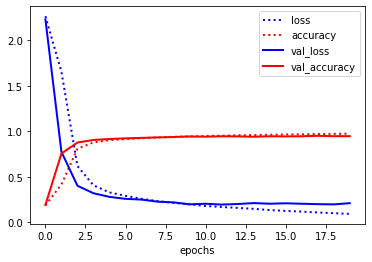

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_183 (Conv2D)          (None, 30, 30, 64)        640       
_________________________________________________________________
batch_normalization_153 (Bat (None, 30, 30, 64)        120       
_________________________________________________________________
re_lu_118 (ReLU)             (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 30, 30, 64)        36928     
_________________________________________________________________
batch_normalization_154 (Bat (None, 30, 30, 64)        120       
_________________________________________________________________
re_lu_119 (ReLU)             (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 15, 15, 64)      

def build_model_2_1():
    model = models.Sequential([
            
        # Block 1
        layers.Conv2D(64, (3, 3), padding="valid", input_shape=(32, 32, 1)),
        layers.BatchNormalization(momentum=0., axis=1),
        layers.ReLU(),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.BatchNormalization(momentum=0., axis=1),
        layers.ReLU(),
        layers.MaxPool2D((2, 2), padding="same"),
        
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.BatchNormalization(momentum=0., axis=1),
        layers.ReLU(),
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.BatchNormalization(momentum=0., axis=1),
        layers.ReLU(),
        layers.MaxPool2D((2, 2), padding="same"),

        layers.Dropout(0.2),
        
        # Block 3
        layers.Conv2D(256, (2, 2), padding="same"),
        layers.BatchNormalization(momentum=0., axis=1),
        layers.ReLU(),
        layers.Conv2D

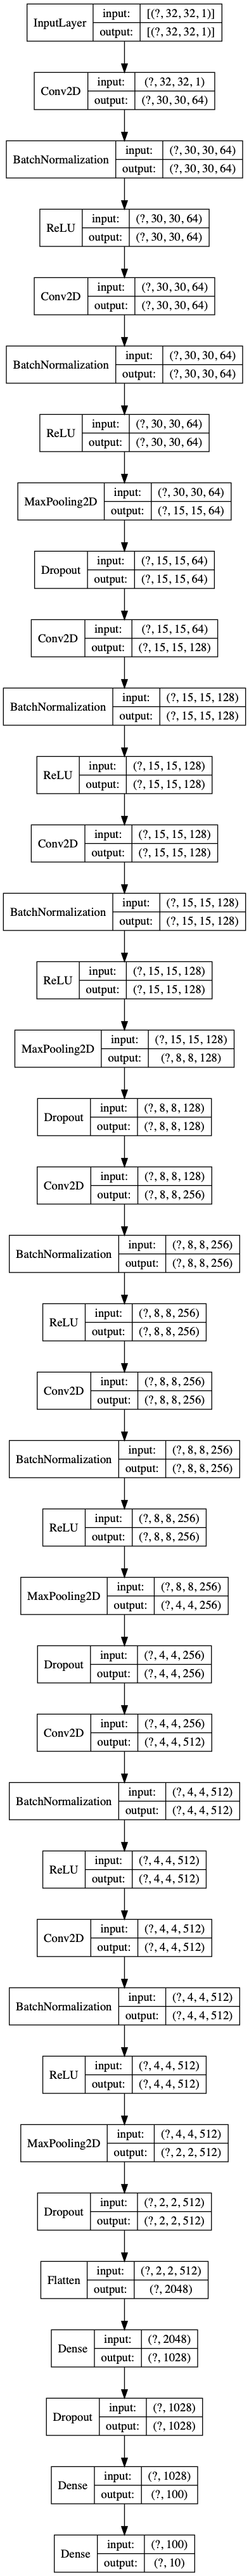

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

To augment the available data I created an image generator that randomly rotated, sheared or shifted (horizontally and vertically) the input images. I found that flipping images did not help, as is sensible to assume given that we are trying to recognise numbers. I also found that it was better to create smaller batches of randomly augmented images, as the number of available images is sufficient. The results are very good, as we achieve a 0.961 validation accuracy with nearly no overfitting (length: 497)



Max val score: 96.10%


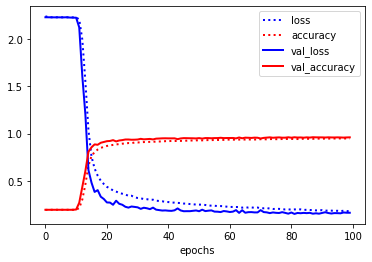


datagen = ImageDataGenerator(
    rotation_range=0.4,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    fill_mode="nearest"
)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Looking at the confusion matrix, there are not a lot of classes that are mixed up with one another. The classes that are most confused are 8 and 6, with the most number of test images that are not predicted correctly. But the accuracy is very high, 0.959 on the test set. Looking at misclassifications, it is clear that a lot of images are unrecognisable even to a human eye (index 2352 and 1091) because of noise. Some other images have a very strange background compared to the other images, with features that may distract the model (index 518 and 2453). Finally, some images are mislabelled. My model actually predicts the correct class, taking into account the most central number to recognise (index 1091). (length: 713)

Test score: 0.96%


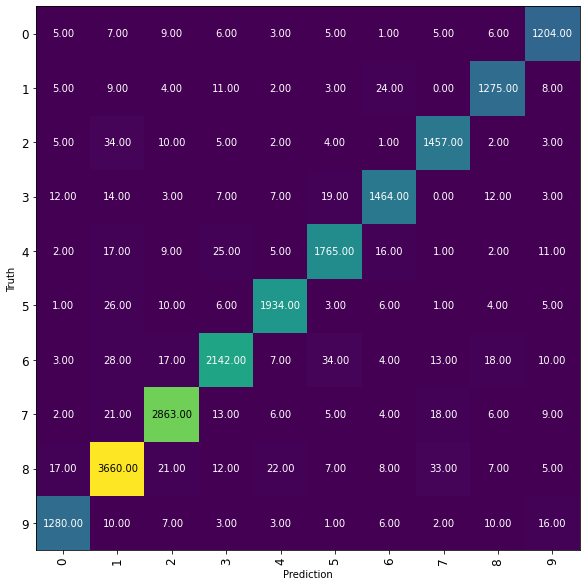

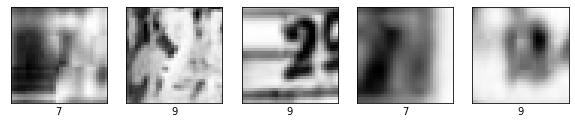

[2352, 518, 2754, 2453, 1091]


In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

Visualising the activations of the filter maps for all Convolutional layers shows that the model is indeed learning useful things. In the first two filter maps there are filters that capture lines of various directions, exemplified by "shadows" that were not present in the input image. As we explore feature maps of block 2, the patterns become more abstract, but we can recognise some patterns such as the S shape of the number 8. Feature maps of blocks 3 and 4 are not comprehensible for us. (length: 495)



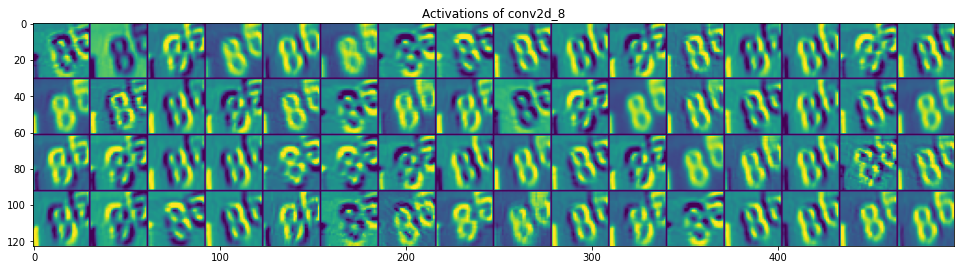

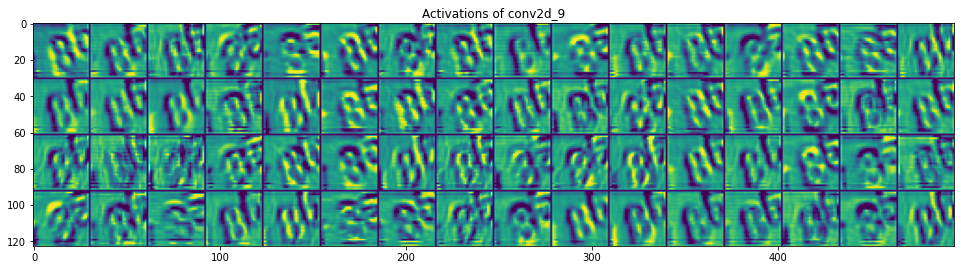

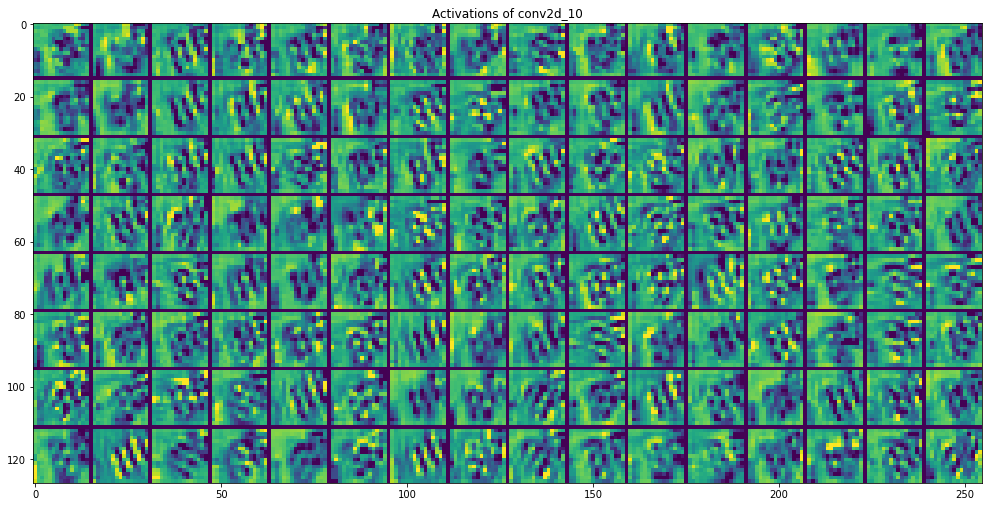

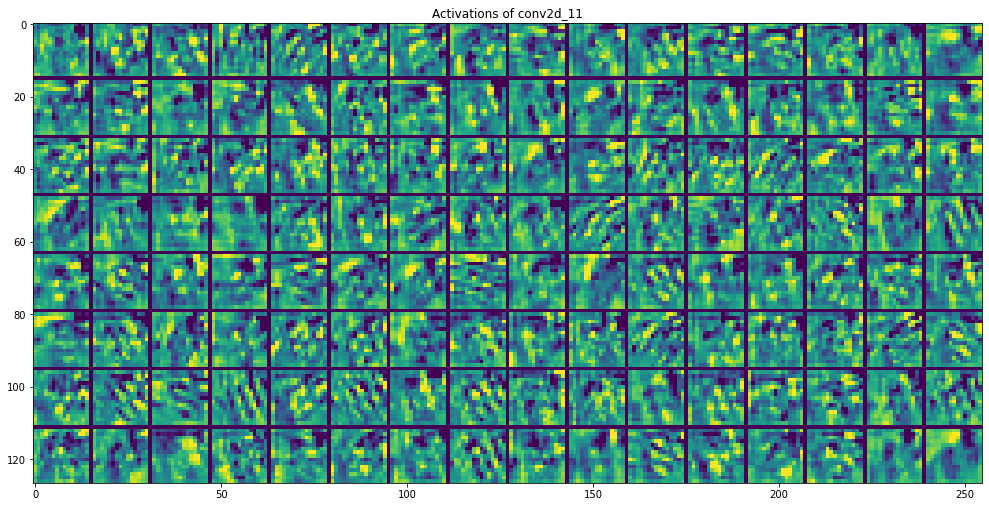

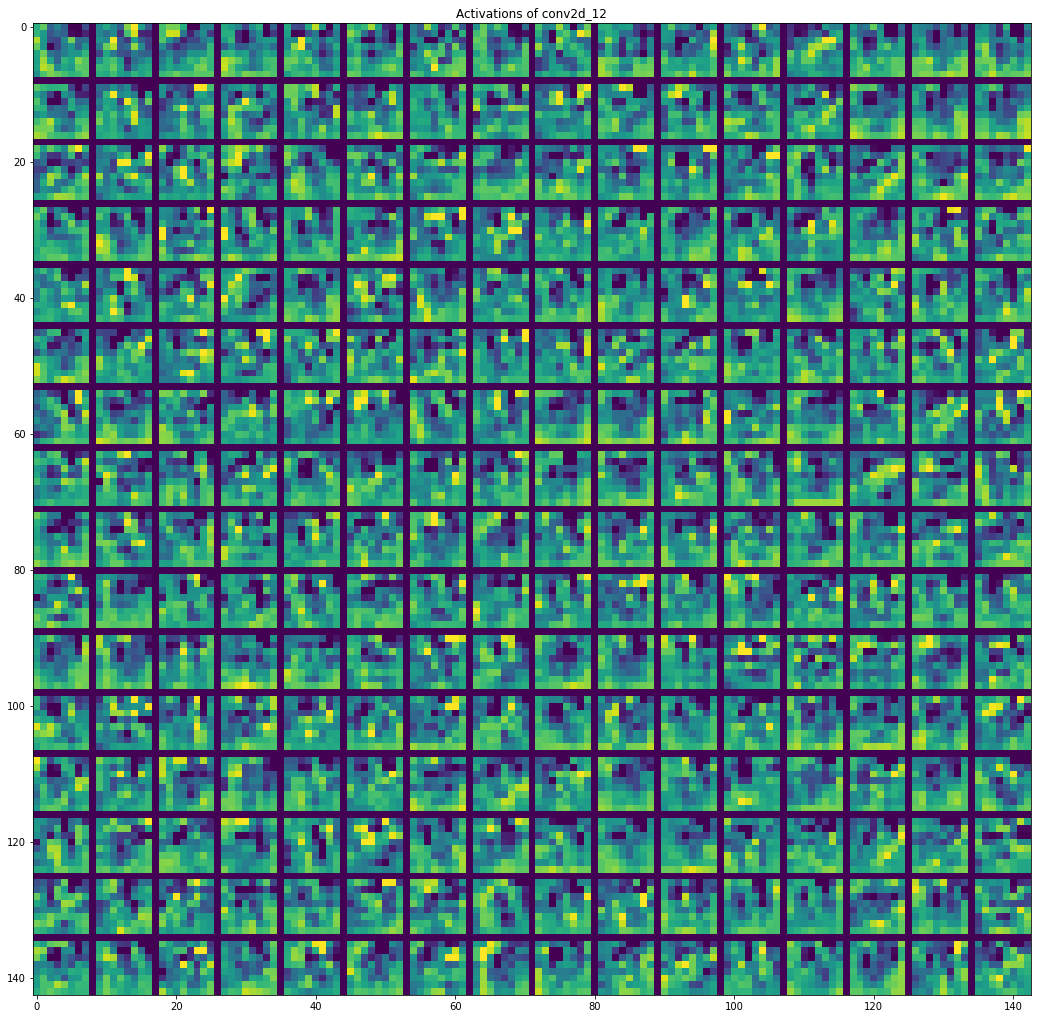

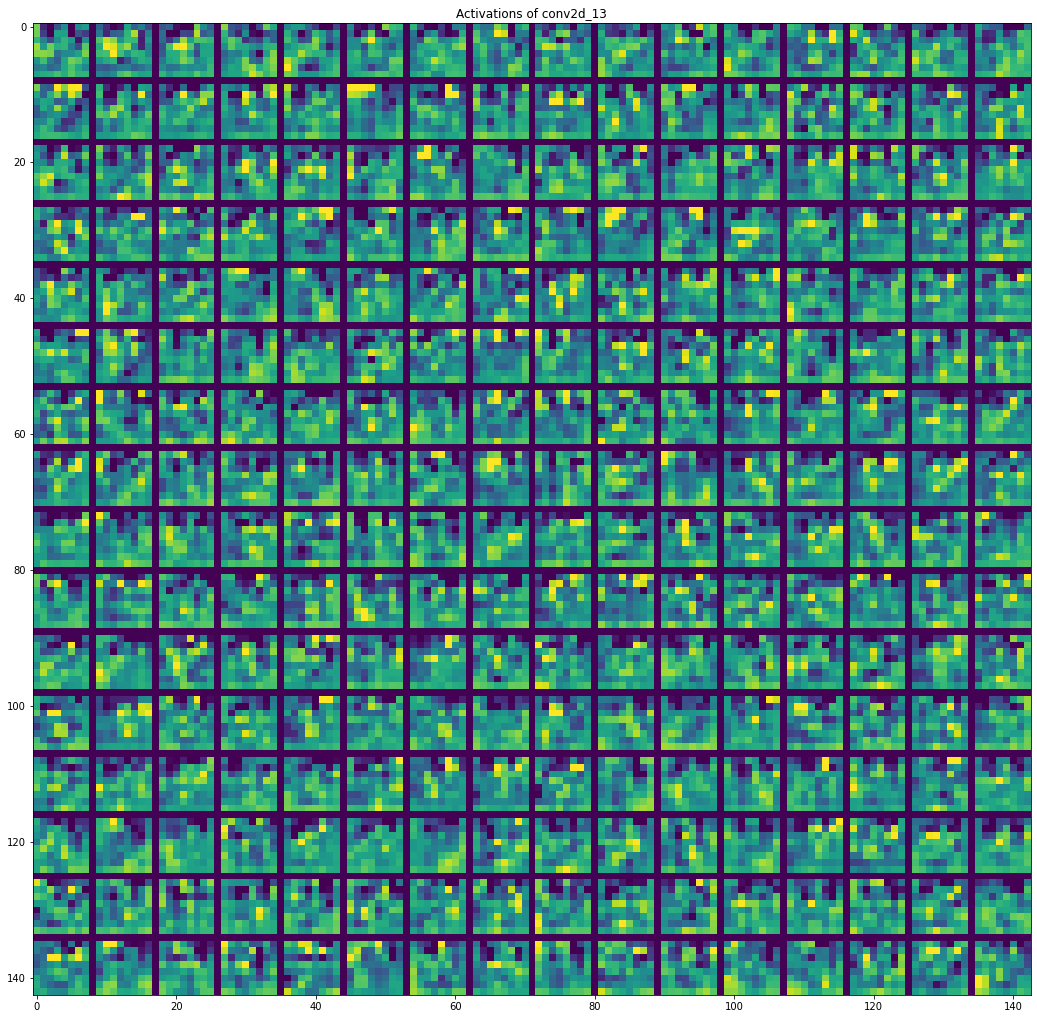

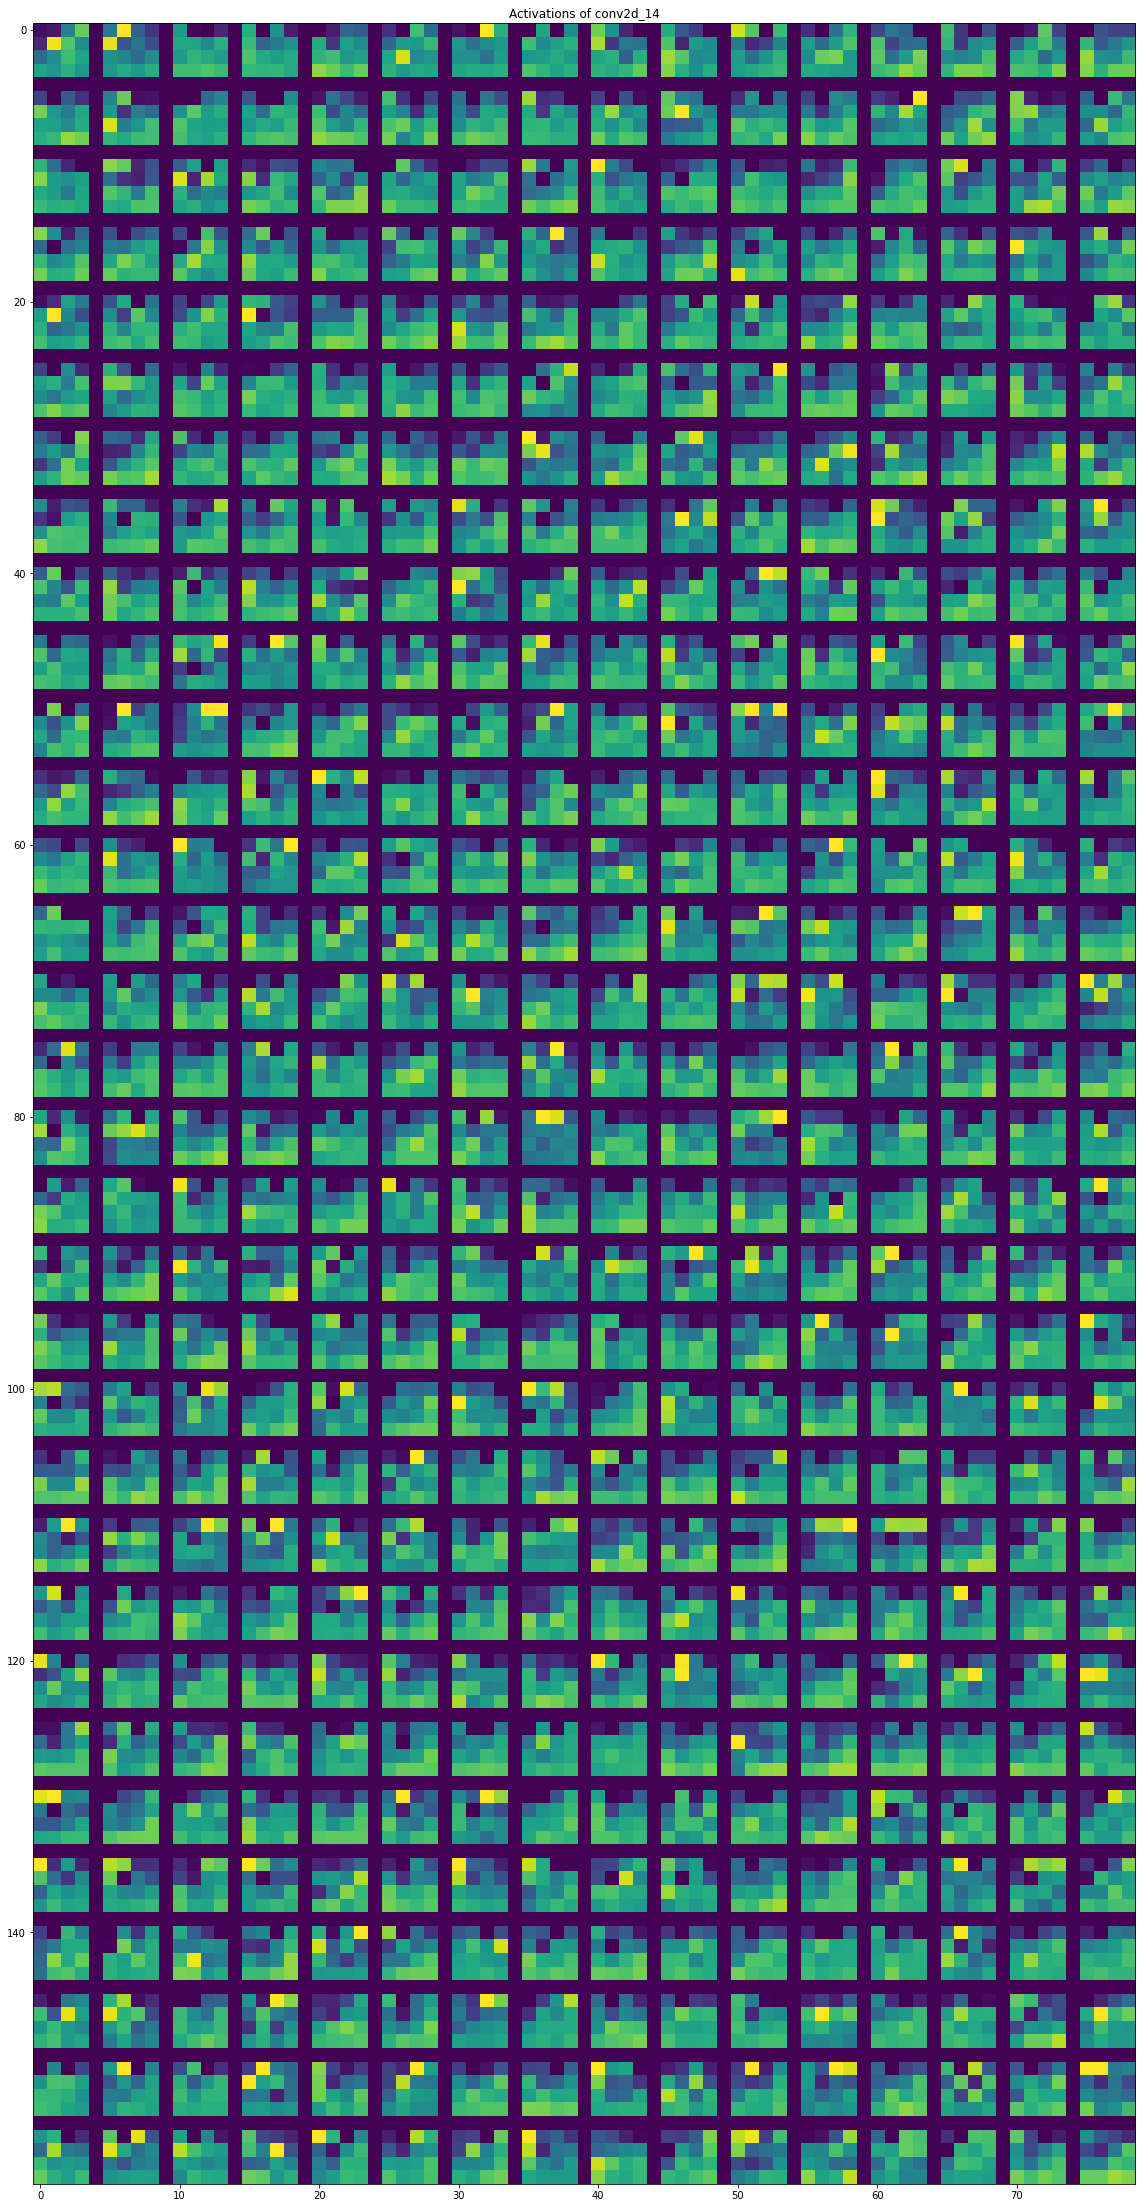

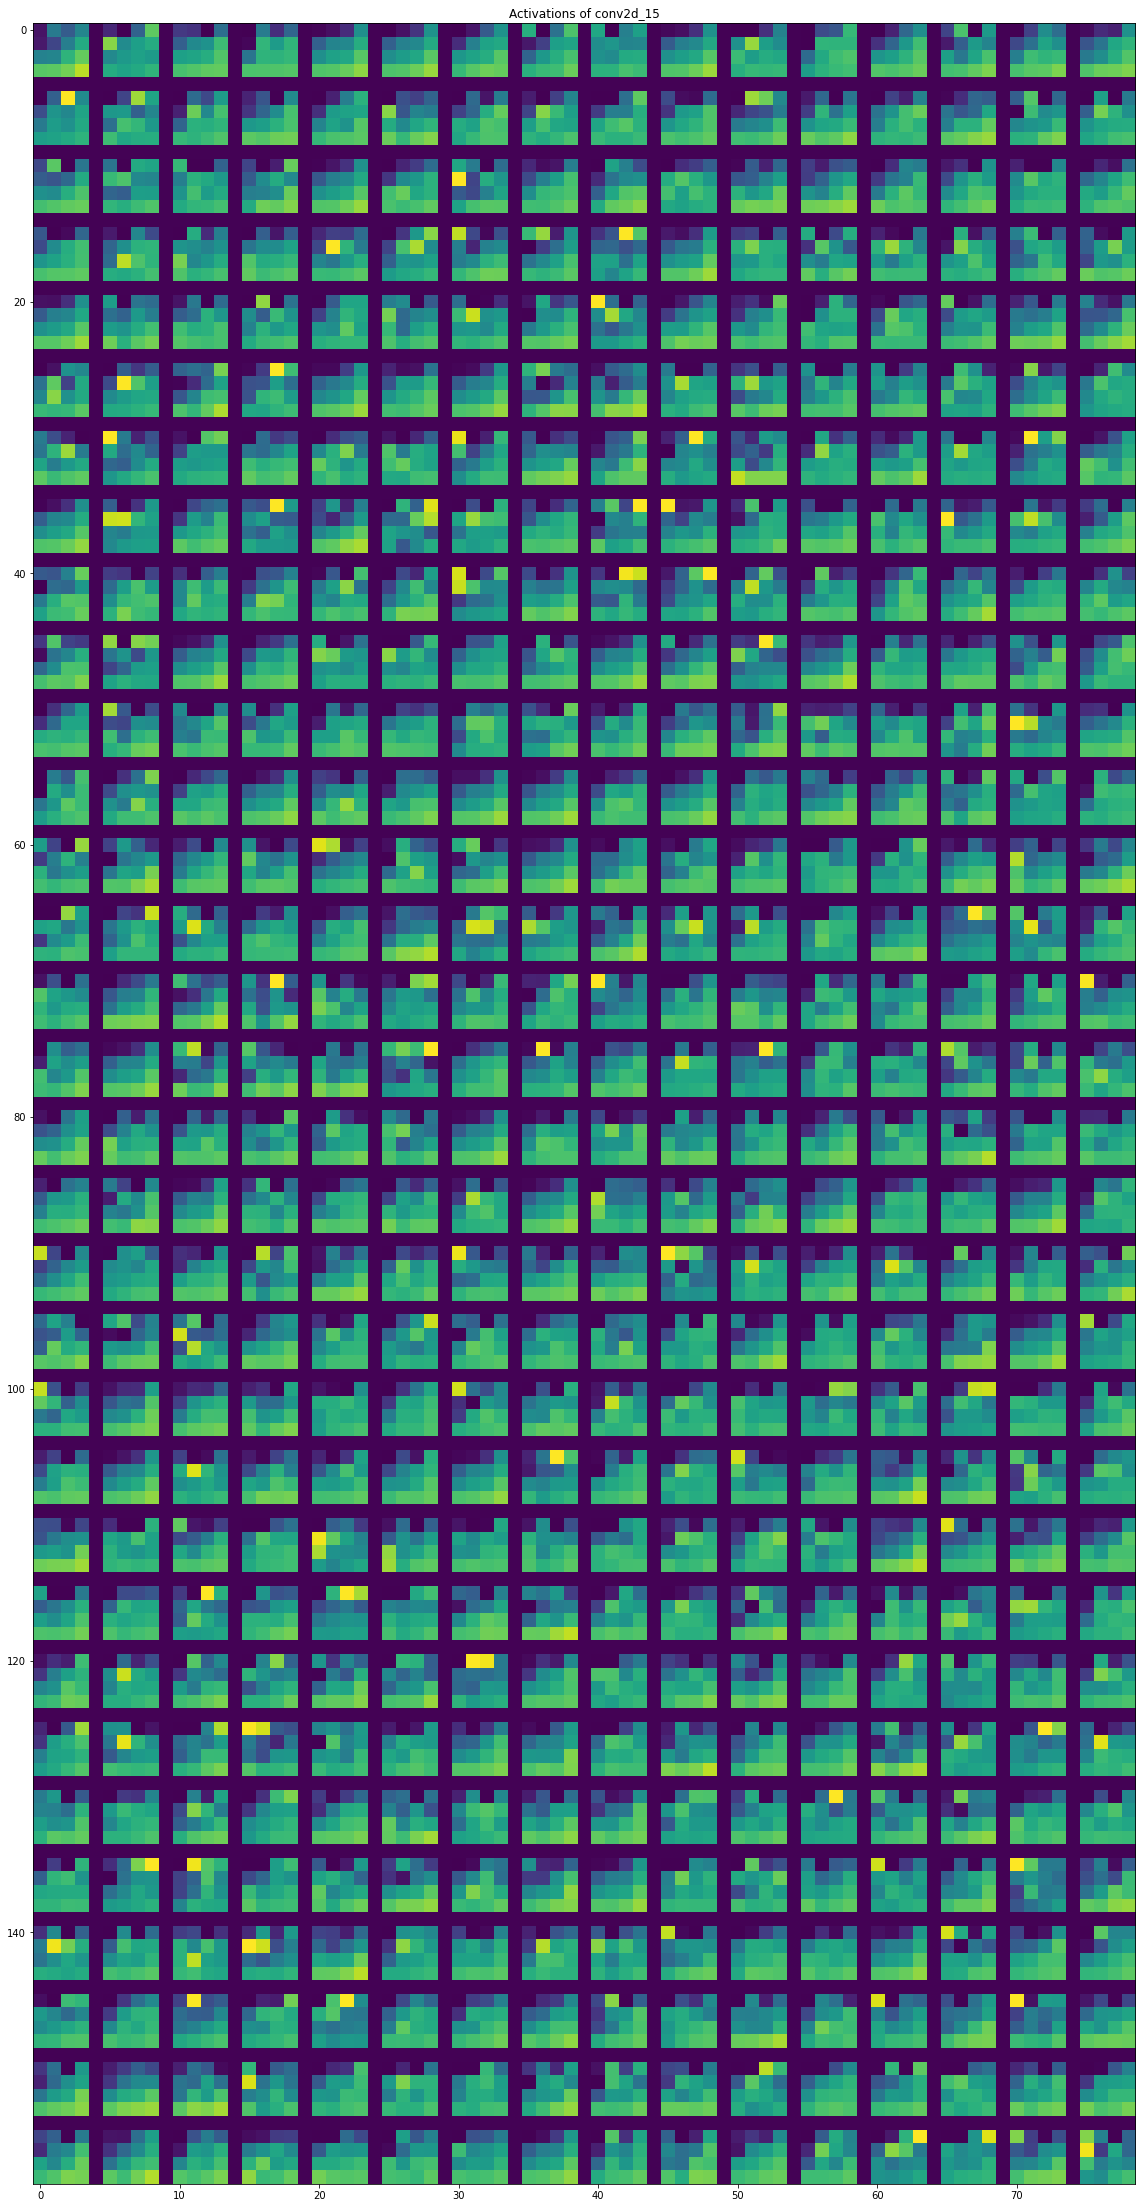

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

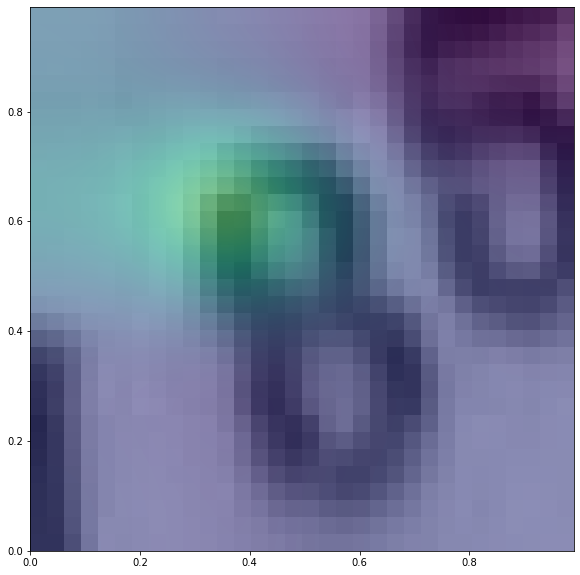

def plot_activation_map():
    channel_activation = build_activation_map()
    
    # Normalise channel activation heatmap between [0, 1]
    channel_min = channel_activation.min()
    channel_max = channel_activation.max()
    channel_activation_norm = (channel_activation - channel_min) / (channel_max - channel_min)
    plt.imshow(channel_activation_norm.squeeze(), cmap="gray")



In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

I added a Dense hidden layer of 100 neurons with ReLU activation on top of the convolutional base of VGG16. Initially, I tried training the model with the convolutional base frozen, but the validation accuracy was not good. I therefore progressively unfroze convolutional layers, but it became apparent that the best scores were achieved by fine-tuning the whole model. I used a low learning rate and used early stopping to avoid potential disasterous loss of information and overfitting. (length: 489)



Max val score: 91.92%


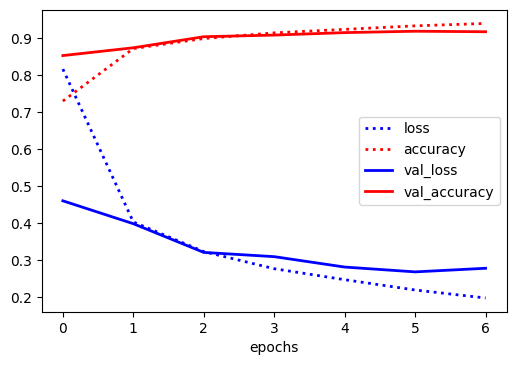

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_27 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_79 (Dense)             (None, 10)                1010      
Total params: 14,766,998
Trainable params: 14,766,998
Non-trainable params: 0
_________________________________________________________________
None


def build_model_4_1():
    vgg16_base = VGG16(include_top=False, weights="imagenet", input_shape=(32,32,3),
                    pooling=None)

    model_4_1 = models.Sequential([
            vgg16_base,
            layers.Flatten(),
            layers.Dense(100, activation="relu"),
            layers.Dense(10, activation="softmax")
    ])

    model_4_1.compile(
        optimizer=optimizers.Adam(learning_rate=1e-05),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model_4_1



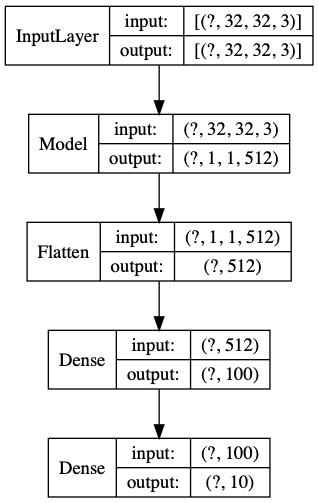

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I implemented a Random Forest as the classifier in my pipeline. I tried applying standard scaling to the embeddings, but the results were not as good as without scaling. This is probably due to the nature of the Random Forest algorithm. I then tuned hyperparameters n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split through Bayesian Optimisation on the validation set. The final test score was 0.953, which is very close to model_2_2's 0.959, obtained on grayscale data. (length: 496)



Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=102, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=6,
                                        n_estimators=871, n_jobs=-1,
                                        oob_score=True))])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_4_1 = load_model_from_file(base_dir=base_dir, name="model_4_1")
    train_embeddings = model_4_1.layers[0].predict(X_train).squeeze()
    test_embeddings = model_4_1.layers[0].predict(X_test).squeeze()
    store_embedding(train_embeddings, "X_train")
    store_embedding(test_embeddings, "X_test")

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    if not os.path.exists(os.path.join(base_dir, "X_train_embedding.p")) or        not os.path.exists(os.path.join(base_dir, "X_

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 177.24 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
